In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import random
%matplotlib inline
import seaborn as sns; sns.set() # for plot styling
import numpy as np
import tarfile
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from sklearn.pipeline import Pipeline
from skimage import io
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
import random
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import mahotas.features.texture as texture

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import sys
sys.path.append('C:/Users/whitm/Documents/GitHub/usd-capstone/')
sys.path.append('C:/Users/whitm/Documents/GitHub/usd-capstone/functions/')
#import img_utils as aug
import resnet

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load full data set

In [5]:
directory = "/Users/whitm/.fastai/data/food-101"
image_list = []
folder_names = []
# Get a list of all subdirectories in the given directory
subdirectories = [f.path for f in os.scandir(directory+ "/images") if f.is_dir()]

# Loop through each subdirectory
for subdirectory in subdirectories:
    # Get the folder name
    folder_name = os.path.basename(subdirectory)

    # Get a list of all image files within the subdirectory
    image_files = [f.path for f in os.scandir(subdirectory) if f.is_file() and f.name.endswith(".jpg")]

    # Loop through each image file
    for image_file in image_files:
        # Append the image file to the image_list
        image_list.append(image_file)
        folder_names.append(folder_name)

In [6]:
labels_file = directory+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

In [7]:
len(image_list)

101000

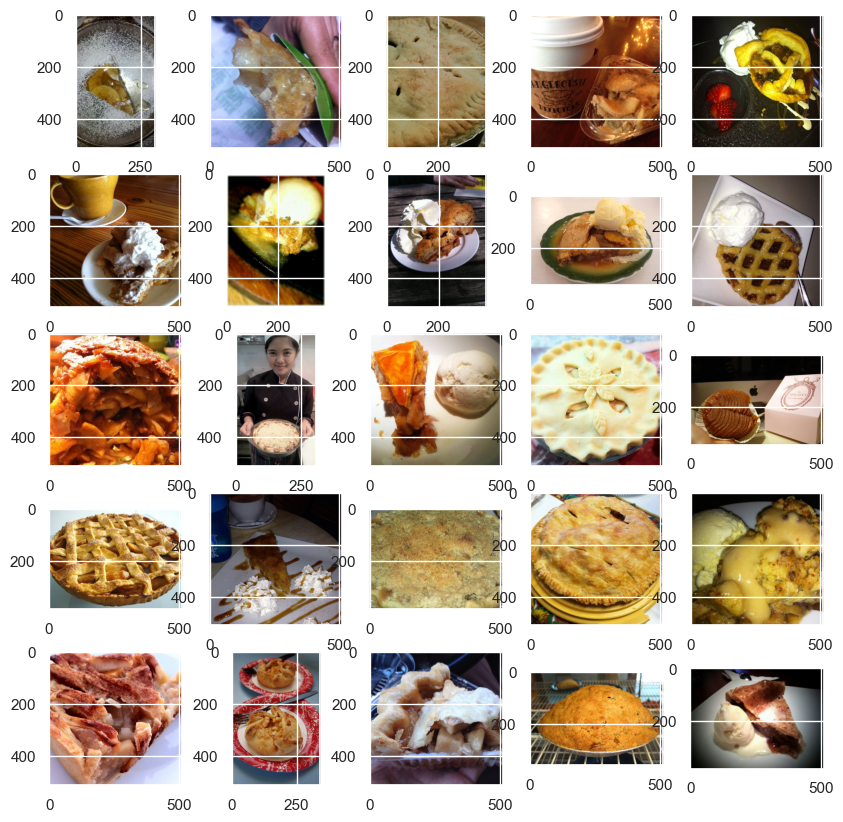

In [8]:
#plot the images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for i in range(25):
    path=image_list[i]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=None)

## Train // Test Split

The dataset has been pre-split as some of the images have required manual removal. Due to the time limitations with this project, we are going to be unable to manually search through over 100,000 images and therefore will rely on the FastAI split.

In [198]:
# Load the category labels
labels_file = directory+'/labels.txt'
with open(labels_file, 'r') as f:
    labels = [label.strip().lower().replace(' ', '_') for label in f.readlines()]

# Load the training dataset
train_file = directory+'/train.txt'
train_data = pd.read_csv(train_file, header=None, names=['category_filename'], dtype=str)
train_data['category'] = train_data['category_filename'].apply(lambda x: x.split('/')[0])
train_data['filename'] = train_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
train_data['filename'] = train_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
train_data['image_path'] = train_data.apply(lambda row: os.path.join(directory, 'images', row['category'], row['filename']), axis=1)

print (train_data.shape)
train_data.head()

(75750, 4)


category_filename   category     filename  \
0  apple_pie/1005649  apple_pie  1005649.jpg   
1  apple_pie/1014775  apple_pie  1014775.jpg   
2  apple_pie/1026328  apple_pie  1026328.jpg   
3  apple_pie/1028787  apple_pie  1028787.jpg   
4  apple_pie/1043283  apple_pie  1043283.jpg   

                                          image_path  
0  /Users/whitm/.fastai/data/food-101\images\appl...  
1  /Users/whitm/.fastai/data/food-101\images\appl...  
2  /Users/whitm/.fastai/data/food-101\images\appl...  
3  /Users/whitm/.fastai/data/food-101\images\appl...  
4  /Users/whitm/.fastai/data/food-101\images\appl...

In [208]:
# Load the test dataset
test_file = directory+'/test.txt'
test_data = pd.read_csv(test_file, header=None, names=['category_filename'], dtype=str)
test_data['category'] = test_data['category_filename'].apply(lambda x: x.split('/')[0])
test_data['filename'] = test_data['category_filename'].apply(lambda x: x.split('/')[1])

# Add the '.jpg' extension to the filenames
test_data['filename'] = test_data['filename'].apply(lambda x: x + '.jpg')

# Construct the image paths
test_data['image_path'] = test_data.apply(lambda row: os.path.join(directory, 'images', row['category'], row['filename']), axis=1)

print (test_data.shape)
test_data.head()

(25250, 4)


category_filename   category     filename  \
0  apple_pie/1011328  apple_pie  1011328.jpg   
1   apple_pie/101251  apple_pie   101251.jpg   
2  apple_pie/1034399  apple_pie  1034399.jpg   
3   apple_pie/103801  apple_pie   103801.jpg   
4  apple_pie/1038694  apple_pie  1038694.jpg   

                                          image_path  
0  /Users/whitm/.fastai/data/food-101\images\appl...  
1  /Users/whitm/.fastai/data/food-101\images\appl...  
2  /Users/whitm/.fastai/data/food-101\images\appl...  
3  /Users/whitm/.fastai/data/food-101\images\appl...  
4  /Users/whitm/.fastai/data/food-101\images\appl...

### Splitting the train and test splits into their own folders for dataset creation later for modeling

In [209]:
import shutil
def creating_folders(df, destination_folder, different_split=False):
    # delete path if making a new train test split
    if different_split == True:
            if os.path.exists(destination_folder):
                shutil.rmtree(destination_folder)

    for path in df['image_path']:
        folder = str(path).split("\\")[-2]

        # making folder if it doesn't exist
        if not os.path.exists(destination_folder + folder + "/"):
            os.makedirs(destination_folder + folder + "/")
        
        # copy images into train or test folder
        shutil.copy(path, destination_folder + folder + "/")


In [211]:
train_destination = '/Users/whitm/.fastai/data/food-101/splits/train/'
test_destination = '/Users/whitm/.fastai/data/food-101/splits/test/'

creating_folders(test_data, test_destination, different_split=True)
creating_folders(train_data, train_destination, different_split=True)

### Observe random images from different categories

In [213]:
for _, i in train_data.groupby('category').apply(lambda x: x.sample(1)).iterrows():
    print(i['image_path'])

/Users/whitm/.fastai/data/food-101\images\apple_pie\3641922.jpg
/Users/whitm/.fastai/data/food-101\images\baby_back_ribs\1563530.jpg
/Users/whitm/.fastai/data/food-101\images\baklava\1245651.jpg
/Users/whitm/.fastai/data/food-101\images\beef_carpaccio\1182085.jpg
/Users/whitm/.fastai/data/food-101\images\beef_tartare\281727.jpg
/Users/whitm/.fastai/data/food-101\images\beet_salad\3094600.jpg
/Users/whitm/.fastai/data/food-101\images\beignets\244724.jpg
/Users/whitm/.fastai/data/food-101\images\bibimbap\2533295.jpg
/Users/whitm/.fastai/data/food-101\images\bread_pudding\3920746.jpg
/Users/whitm/.fastai/data/food-101\images\breakfast_burrito\1578574.jpg
/Users/whitm/.fastai/data/food-101\images\bruschetta\820545.jpg
/Users/whitm/.fastai/data/food-101\images\caesar_salad\793492.jpg
/Users/whitm/.fastai/data/food-101\images\cannoli\383934.jpg
/Users/whitm/.fastai/data/food-101\images\caprese_salad\288219.jpg
/Users/whitm/.fastai/data/food-101\images\carrot_cake\1450179.jpg
/Users/whitm/.fa

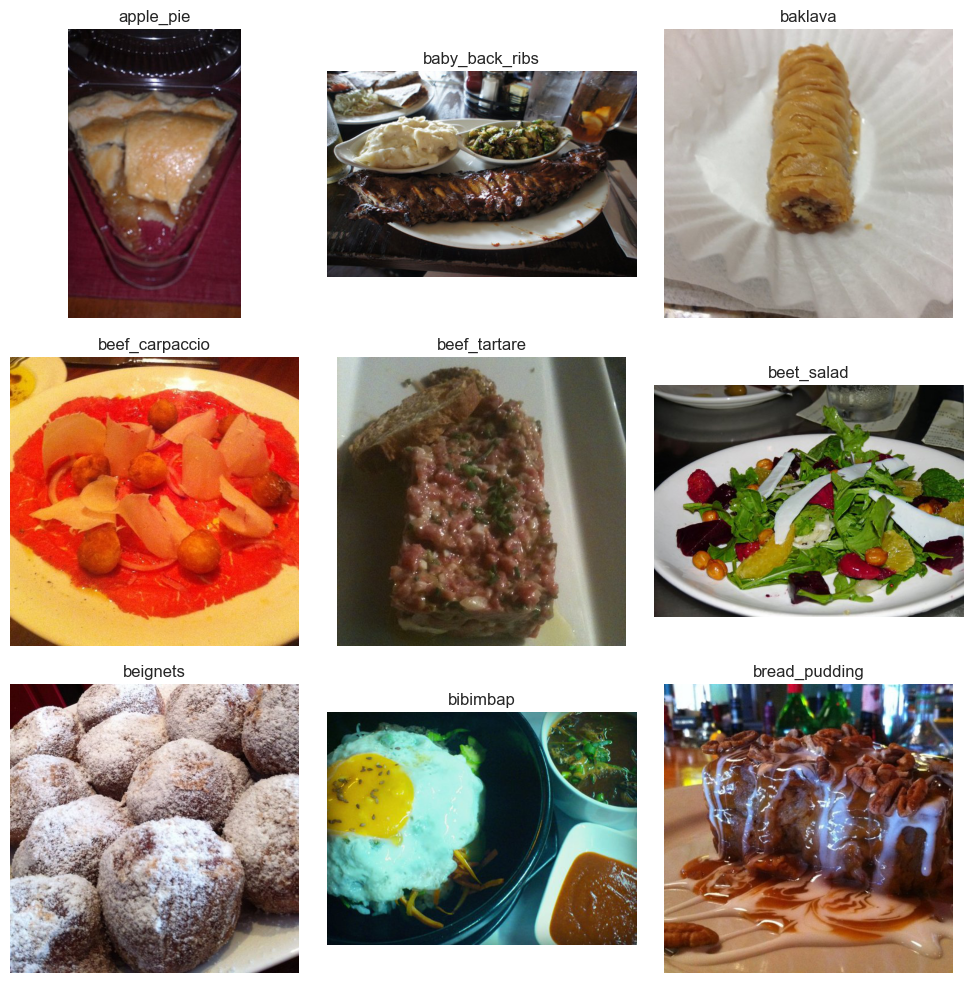

In [214]:
# Load a random sample of images from different categories
sample_images = train_data.groupby('category').apply(lambda x: x.sample(1))
sample_images_paths = []
for _, row in sample_images.iterrows():
    category = row['category']
    image_path = row['image_path']
    #image_path = f'{directory}/images/{category}/{filename}'
    sample_images_paths.append(image_path)

plt.figure(figsize=(10, 10))
num_images = min(len(sample_images_paths), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i, image_path in enumerate(sample_images_paths[:num_images]):
    plt.subplot(num_rows, num_cols, i+1)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(sample_images.iloc[i]['category'])
    plt.axis('off')
plt.tight_layout()
plt.show()

### Observe images from apple pie category

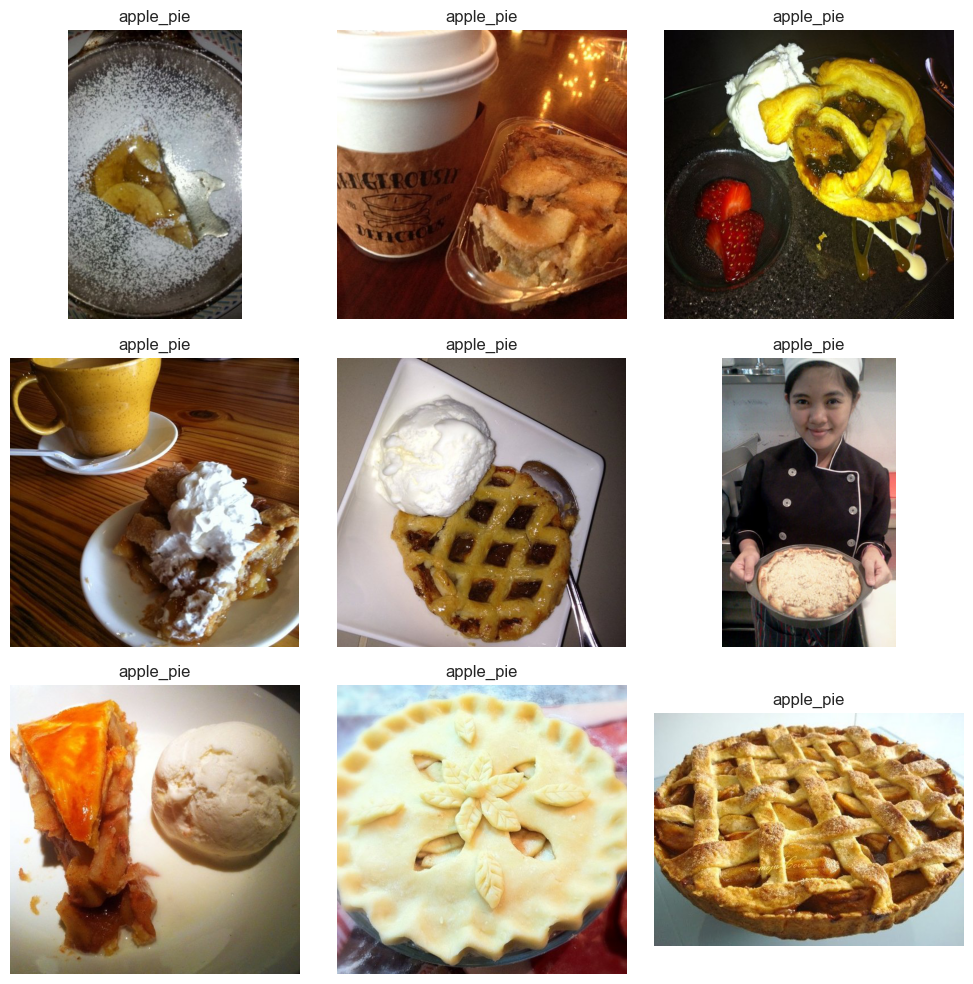

In [215]:
# Specify the category you want to plot
category_to_plot = "apple_pie"

# Filter the train_data based on the specified category
category_data = train_data[train_data['category'] == category_to_plot]

plt.figure(figsize=(10, 10))
num_images = min(len(category_data), 9)
num_rows = num_cols = int(num_images ** 0.5)
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    image_path = category_data.iloc[i]['image_path']
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(image)  # Display the image
    plt.title(category_to_plot)
    plt.axis('off')
plt.tight_layout()
plt.show()

## EDA

### Explore the distribution of image size

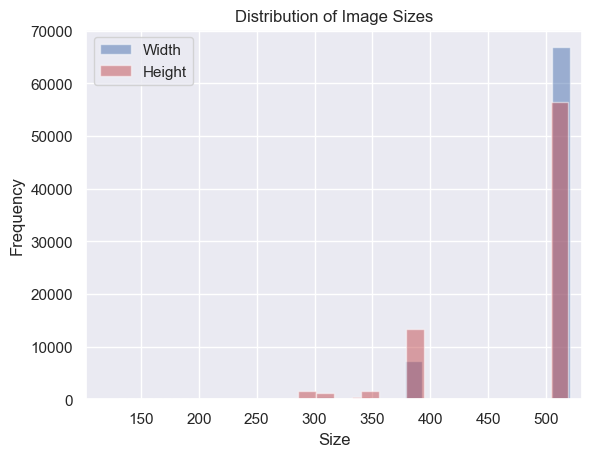

In [217]:
# Distribution of image sizes
image_sizes = []
for image_path in train_data['image_path']:
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_sizes.append((width, height))
    
#plot the distribution
widths, heights = zip(*image_sizes)
plt.hist(widths, bins=50, alpha=0.5, color='b', label='Width', width=15)
plt.hist(heights, bins=50, alpha=0.5, color='r', label='Height', width=15)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Image Sizes')
plt.show()

 --> Most images have high values of height and width around 525 pixels, another size shows the next high frequency is around 375 pixels.

### Explore the distribution of mean intesity and contrast of the categories

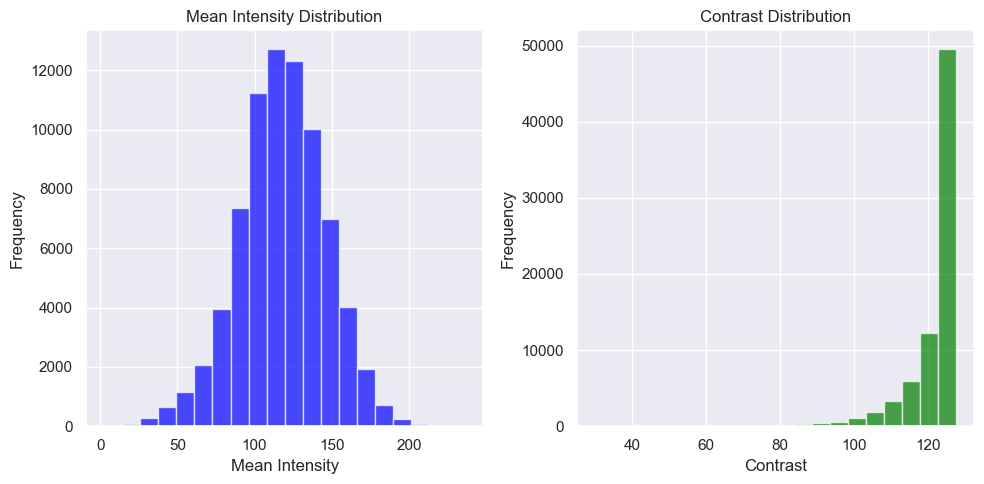

In [218]:
# Compute the mean intensity and contrast of images in the train_data dataset
mean_intensities = []
contrasts = []

for _, row in train_data.iterrows():
    image_path = row['image_path']
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the mean intensity
    mean_intensity = np.mean(gray)
    mean_intensities.append(mean_intensity)
    
    # Compute the contrast
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contrast = np.std(thresholded)
    contrasts.append(contrast)

# Plot the mean intensity and contrast
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(mean_intensities, bins=20, color='blue', alpha=0.7)
plt.title('Mean Intensity Distribution')
plt.xlabel('Mean Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(contrasts, bins=20, color='green', alpha=0.7)
plt.title('Contrast Distribution')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

-->The mean intensity shows normal distribution of all images while contrast shows left skew distribution

### Explore the distribution of mean intesity and contrast values  for random 5 categories

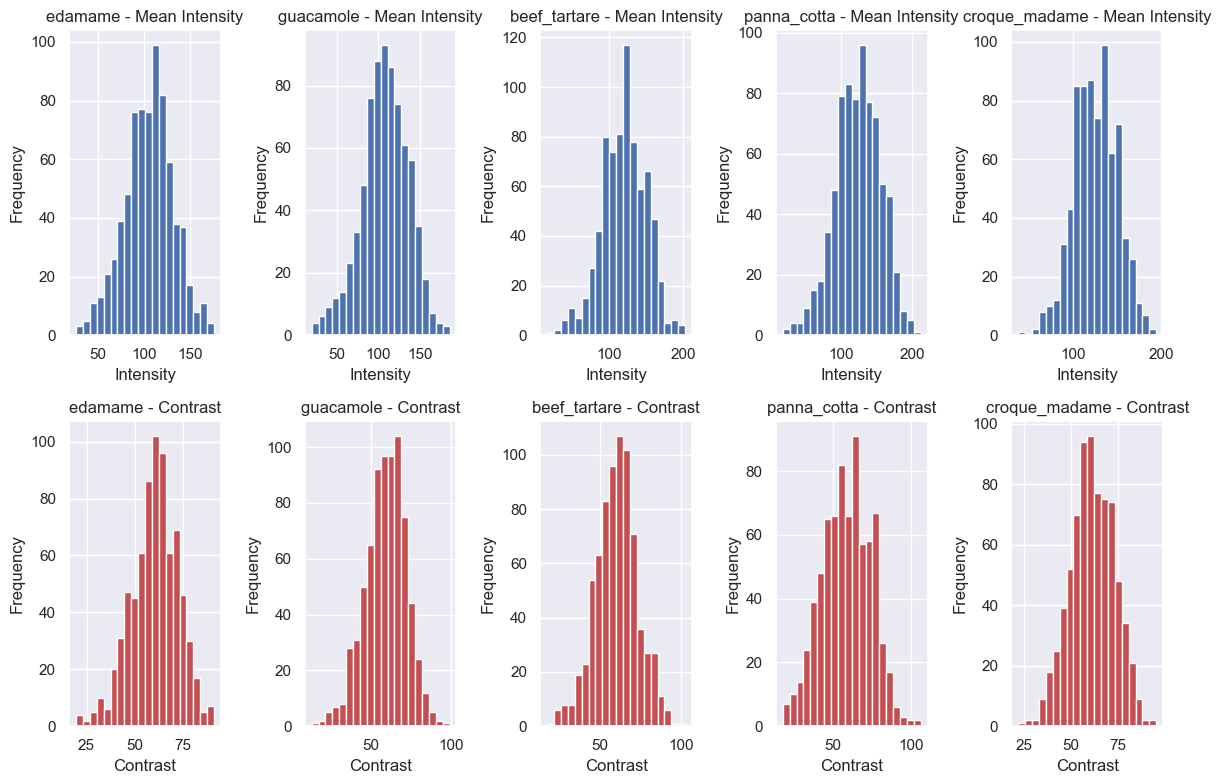

In [219]:
# Randomly select a subset of categories
num_categories = 5  
selected_categories = random.sample(labels, num_categories)

# Calculate and plot intensity and contrast for each category
plt.figure(figsize=(12, 8))
for i, category in enumerate(selected_categories):
    category_data = train_data[train_data['category'] == category]
    image_paths = category_data['image_path'].tolist()
    
    mean_intensities = []
    contrasts = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        intensity = np.mean(gray) 
        contrast = np.std(gray) 
        mean_intensities.append(intensity)
        contrasts.append(contrast)
        
    plt.subplot(2, num_categories, i + 1)
    plt.hist(mean_intensities, bins=20, color='b')
    plt.title(f'{category} - Mean Intensity')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.subplot(2, num_categories, num_categories + i + 1)
    plt.hist(contrasts, bins=20, color='r')
    plt.title(f'{category} - Contrast')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

 --> The distribution of mean intensity and contrast in each category selected randomly show normal or close to normal ditribution. 

### Explore the texture of the images from each category

In [220]:
    
# Function to compute Haralick texture features for an image
def compute_haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = texture.haralick(gray)
    features = haralick.mean(axis=0)
    return features

# Analyze texture features for each category
texture_features = []
for category in labels:
    category_data = train_data[train_data['category'] == category]
    image_paths = category_data['image_path'].tolist()
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        features = compute_haralick_features(image)
        texture_features.append(features)

In [221]:
texture_features[:5]

[array([ 1.69286290e-04,  2.35126980e+02,  9.55430016e-01,  2.63855958e+03,
         1.48630247e-01,  2.30281812e+02,  1.03191114e+04,  8.60498668e+00,
         1.31818615e+01,  1.85279741e-04,  4.82805422e+00, -2.68665863e-01,
         9.90988830e-01]),
 array([ 6.16319257e-04,  7.68535474e+01,  9.91248587e-01,  4.39187776e+03,
         2.97963145e-01,  2.01227192e+02,  1.74906575e+04,  8.70218243e+00,
         1.21462938e+01,  4.30574689e-04,  3.76183972e+00, -4.26244489e-01,
         9.99229564e-01]),
 array([ 1.03076011e-03,  1.74537553e+02,  9.82190822e-01,  4.89970615e+03,
         2.80742476e-01,  1.41525625e+02,  1.94242871e+04,  8.12509429e+00,
         1.18830109e+01,  3.34708057e-04,  4.19765944e+00, -3.36927254e-01,
         9.95719895e-01]),
 array([ 4.61236704e-04,  1.11746178e+02,  9.86016400e-01,  3.99553893e+03,
         2.65626945e-01,  1.82349505e+02,  1.58704095e+04,  8.59506169e+00,
         1.22645381e+01,  3.79490564e-04,  3.95247424e+00, -3.87064013e-01,
       

I ended up not getting this code segment to run. I think there must be a missing segment to create df_mean?

In [ ]:
# Observe texture feature distibution for some categories 
num_categories_to_plot = 6 

plt.figure(figsize=(15, 10))

for i, category in enumerate(df_mean.index[:num_categories_to_plot]):
    plt.subplot(2, 3, i+1)
    plt.bar(df_mean.columns, df_mean.loc[category])
    plt.title(f'{category} - Average Texture Feature Values')
    plt.xlabel('Texture Features')
    plt.ylabel('Average Feature Value')
    plt.xticks(rotation=45)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


Prominent features in the plot are:

Haralick Texture Feature 4: Sum of Squares Variance - It captures the variance of pixel intensities in the image.
Haralick Texture Feature 7: Sum Variance - It captures the variance of the sum values of local image regions.

--> The first 6 categories plots indicate distinct patterns and textures in the image and highlight contrast and variations in intensity or brightness

### Sample Data Augmentation

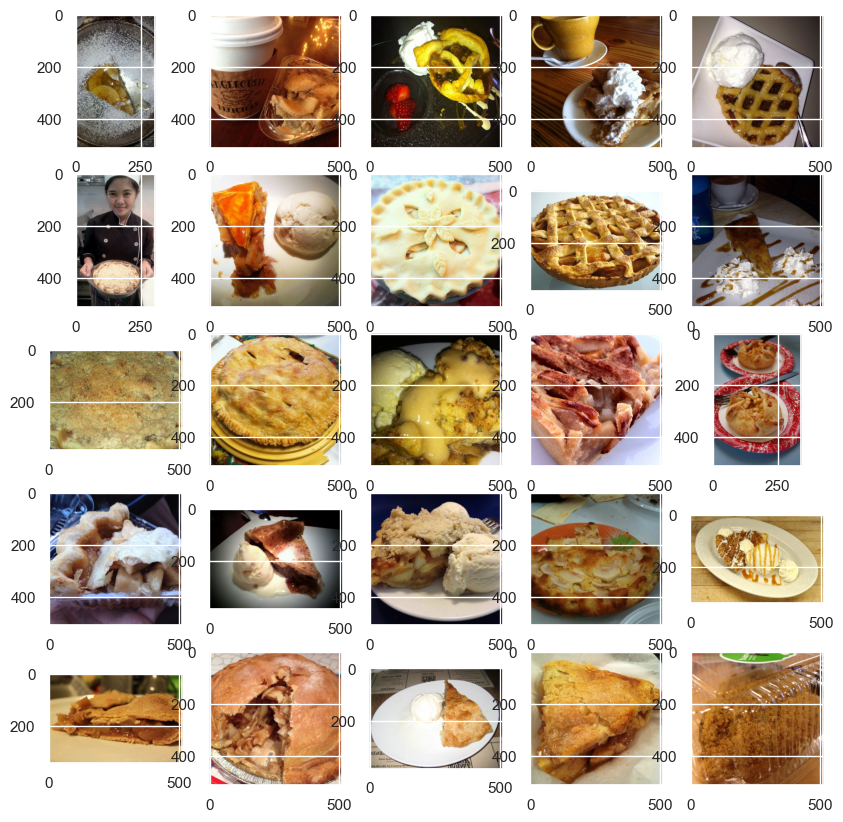

In [222]:
#plot the images
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = ax.flatten()
for i in range(25):
    path=train_data['image_path'].iloc[i]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img, cmap=None)


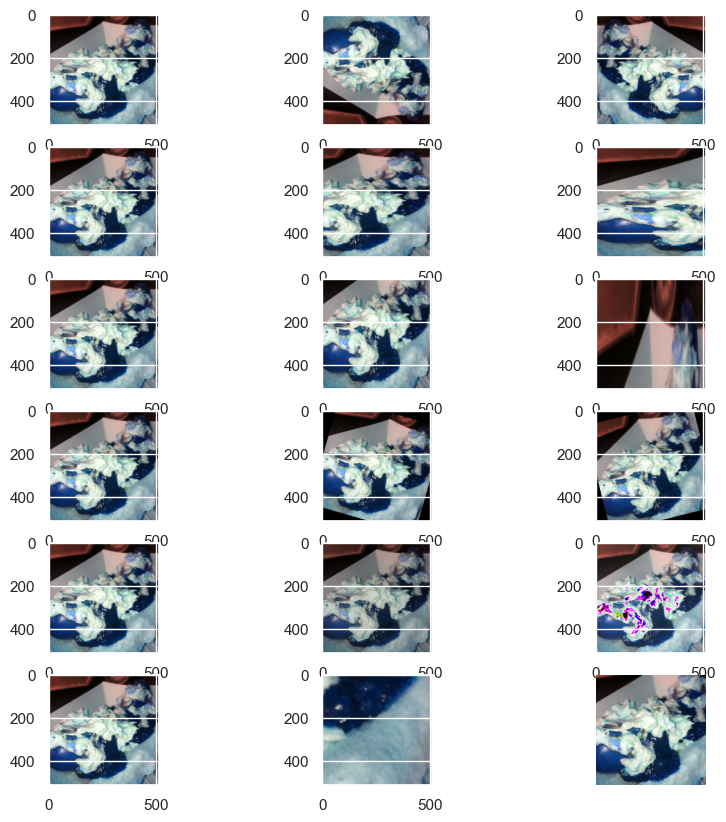

In [25]:
img = cv2.imread(train_data['image_path'].iloc[90])
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(10, 10))
axes = ax.flatten()

# Flipping Image
axes[0].imshow(img)
axes[1].imshow(aug.vertical_flip(img,True))
axes[2].imshow(aug.horizontal_flip(img,True))

# Horizontal Shifting Image
axes[3].imshow(img)
axes[4].imshow(aug.horizontal_shift(img,0.5))
axes[5].imshow(aug.horizontal_shift(img,0.9))

# Vertical Shifting Image
axes[6].imshow(img)
axes[7].imshow(aug.vertical_shift(img,0.5))
axes[8].imshow(aug.vertical_shift(img,0.9))

# Rotating Image
axes[9].imshow(img)
axes[10].imshow(aug.rotation(img,45))
axes[11].imshow(aug.rotation(img,90))

# Recolor Image
axes[12].imshow(img)
axes[13].imshow(aug.brightness(img,0.3,2))
axes[14].imshow(aug.channel_shift(img,90))

# Zoom Image
axes[15].imshow(img)
axes[16].imshow(aug.zoom(img,0.2))
axes[17].imshow(aug.zoom(img,0.6))

plt.axis('off')
plt.show()

## Creating datasets for modeling training and testing

In [223]:
di = "/Users/whitm/.fastai/data/food-101/splits/train/"
test_di = '/Users/whitm/.fastai/data/food-101/splits/test/'

### Data Gens


In [228]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 5,
    zoom_range = (0.5, 0.95),
    horizontal_flip = True,
    vertical_flip = True,
    data_format = 'channels_last',
    validation_split=0.0,
    dtype=tf.float32

)

In [237]:
testgen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    dtype=tf.float32
)

In [230]:
train_gen = datagen.flow_from_directory(
    di,
    target_size = (224,224),
    color_mode='rgb',
    class_mode='sparse',
    shuffle=True,
    seed=33
)

Found 75750 images belonging to 101 classes.


In [251]:
test_gen = testgen.flow_from_directory(
    test_di,
    target_size = (224,224),
    color_mode='rgb',
    class_mode='sparse',
    batch_size = 1,
    shuffle = False,
    seed=33
)

Found 25250 images belonging to 101 classes.


I ended up augmenting with tf rather than Ivan's augmentation. I struggled to load models appropriately when using the other augmentation techiniques in a similar way. Perhaps I am using them wrong. 

In [128]:
def augment(x, y):
    image = tf.image.resize(x, [224,224])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.5)
    image = tf.image.random_contrast(image, 0.2, 0.7)
    image = tf.image.random_hue(image, 0.5)
    image = tf.image.random_saturation(image, 0.1, 0.7)
    return image, y

## ResNet 34

In [67]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = 'relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides = strides,
                                padding = 'same', use_bias = False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides = 1,
                                padding = 'same', use_bias = False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides = strides,
                                    padding = 'same', use_bias = False),
                keras.layers.BatchNormalization()]

In [68]:
def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
        Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
        skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [69]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape=[224, 224, 3],
                              padding = 'same', use_bias = False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides  = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(101, activation = 'softmax'))

In [73]:
model.compile(loss = [keras.losses.SparseCategoricalCrossentropy(from_logits=True)], optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['sparse_categorical_accuracy'])

So far, trying to reach a high training accuracy on the ResNet 34 has been unsuccessful as it is a more shallow version of the ResNet.  

In [74]:
model.fit(train_gen, epochs = 50, batch_size = 32)

Epoch 1/50
2525/2525 [==============================] - 820s 324ms/step - loss: 4.4117 - sparse_categorical_accuracy: 0.0443
Epoch 2/50
1652/2525 [==================>...........] - ETA: 4:49 - loss: 4.3001 - sparse_categorical_accuracy: 0.0607

KeyboardInterrupt: 

## ResNet50

In [232]:
res = keras.applications.resnet50.ResNet50(weights=None, include_top = False, input_shape=(224,224,3))
x = res.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(101, activation = 'softmax')(x)
mod = keras.Model(inputs = res.input, outputs = predictions)

In [233]:
mod.compile(loss = [keras.losses.SparseCategoricalCrossentropy(from_logits=True)], optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['sparse_categorical_accuracy'])

Trained to 35 epochs, the categorical accuracy is still climbing, although slowing, could potentially be improved with more epochs. 35 epochs took approximately 475 minutes.

In [234]:
mod.fit(train_gen, epochs = 35, batch_size = 32)

Epoch 1/35
2368/2368 [==============================] - 1163s 489ms/step - loss: 4.5656 - sparse_categorical_accuracy: 0.0412
Epoch 2/35
2368/2368 [==============================] - 823s 347ms/step - loss: 4.2173 - sparse_categorical_accuracy: 0.0682
Epoch 3/35
2368/2368 [==============================] - 811s 343ms/step - loss: 3.9723 - sparse_categorical_accuracy: 0.0987
Epoch 4/35
2368/2368 [==============================] - 812s 343ms/step - loss: 3.7879 - sparse_categorical_accuracy: 0.1293
Epoch 5/35
2368/2368 [==============================] - 819s 346ms/step - loss: 3.6068 - sparse_categorical_accuracy: 0.1604
Epoch 6/35
2368/2368 [==============================] - 825s 348ms/step - loss: 3.4262 - sparse_categorical_accuracy: 0.1902
Epoch 7/35
2368/2368 [==============================] - 795s 336ms/step - loss: 3.3209 - sparse_categorical_accuracy: 0.2120
Epoch 8/35
2368/2368 [==============================] - 821s 347ms/step - loss: 3.1517 - sparse_categorical_accuracy: 0.2445

#### Predictions
The Model is clearly struggling mightily to make accurate predictions at this point.

In [252]:
preds = mod.predict(test_gen)
predictions = np.argmax(preds, axis = 1)
y_true = test_gen.classes

In [262]:
print("Overall ResNet50 Accuracy: ", round(sklearn.metrics.accuracy_score(y_true, predictions)*100, 2) , "%")

Overall ResNet50 Accuracy:  42.34 %


In [256]:
print(predictions)

[ 31  64  41 ... 100  42  80]


In [257]:
print(y_true)

[  0   0   0 ... 100 100 100]


## MobileNet

In [143]:
mobile = keras.applications.MobileNet(weights=None, include_top = False, input_shape=(224,224,3))
x = augmentation
x = mobile.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x)
predictions = keras.layers.Dense(101, activation = 'softmax')(x)
mob = keras.Model(inputs = mobile.input, outputs = predictions)

In [144]:
mob.compile(loss = [keras.losses.SparseCategoricalCrossentropy(from_logits=True)], optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics = ['sparse_categorical_accuracy'])

In [145]:
mob.fit(train_gen, epochs = 10, batch_size = 32)

Epoch 1/10
2525/2525 [==============================] - 888s 351ms/step - loss: 4.2709 - sparse_categorical_accuracy: 0.0584
Epoch 2/10
2479/2525 [============================>.] - ETA: 15s - loss: 3.8107 - sparse_categorical_accuracy: 0.1156

KeyboardInterrupt: 

In [ ]:
preds = mod.predict(test_gen)
predictions = np.argmax(preds, axis = 1)
y_true = test_gen.classes

In [ ]:
sklearn.metrics.accuracy_score(y_true, predictions)